# Access to WCS data

The CEDA data server at <https://data.cci.ceda.ac.uk/> provides access via the OGC Web Coverage Service (WCS) to CCI datasets. This notebook demonstrates how to retrieve CCI data via WCS from the CEDA server, using [OWSLib](https://www.osgeo.org/projects/owslib/) as the client.

If `owslib` is not already installed in the Python environment, uncomment the following cell to install it with mamba.

In [1]:
# ! mamba install --yes owslib

Import some required libraries, including OWSLib as the WCS client.

In [2]:
from owslib.wcs import WebCoverageService
import xarray as xr
from esa_climate_toolbox.core import list_ecvs, list_ecv_datasets
%matplotlib inline
import matplotlib.pyplot as plt

<frozen abc>:106: FutureWarning: xarray subclass VectorDataCube should explicitly define __slots__


Define a simple convenience class `CciWcs` to manage the web service.

In [3]:
class CciWcs:

    def __init__(self, dataset_id: str):
        self.service = WebCoverageService(
            f"https://data.cci.ceda.ac.uk/thredds/wcs/{dataset_id}?service=WCS&version=1.0.0",
            version="1.0.0"
        )
        
    def coverage(self, data_id: str, bbox: tuple[float]) -> xr.Dataset:
        coverage = self.service.getCoverage(
          identifier=data_id,
          bbox=bbox,
          format="NetCDF3",
          timeout=600
        )
        with open("coverage.nc", "wb") as fh:
            fh.write(coverage.read())
        return xr.open_dataset("coverage.nc")

List the available ECVs.

In [4]:
list_ecvs()

['SEASTATE',
 'AEROSOL',
 'SEAICE',
 'ICESHEETS',
 'BIOMASS',
 'RD',
 'PERMAFROST',
 'OC',
 'SOILMOISTURE',
 'SST',
 'VEGETATION',
 'FIRE',
 'GHG',
 'WATERVAPOUR',
 'SNOW',
 'LC',
 'SEASURFACESALINITY',
 'LAKES',
 'LST',
 'OZONE',
 'CLOUD',
 'SEALEVEL']

List the available datasets for the Land Surface Temperature (LST) ECV.

In [5]:
print("\n".join(map(lambda x: x[0], list_ecv_datasets("LST"))))

esacci.LST.3-hours.L3S.LST.multi-sensor.multi-platform.IRMGP.1-00.r1
esacci.LST.day.L3C.LST.AATSR.Envisat.ATSR_3.3-00.DAY
esacci.LST.day.L3C.LST.AATSR.Envisat.ATSR_3.3-00.NIGHT
esacci.LST.day.L3C.LST.ATSR-2.ERS-2.ATSR_2.3-00.DAY
esacci.LST.day.L3C.LST.ATSR-2.ERS-2.ATSR_2.3-00.NIGHT
esacci.LST.day.L3C.LST.MODIS.Aqua.MODISA.3-00.DAY
esacci.LST.day.L3C.LST.MODIS.Aqua.MODISA.3-00.NIGHT
esacci.LST.day.L3C.LST.MODIS.Terra.MODIST.3-00.DAY
esacci.LST.day.L3C.LST.MODIS.Terra.MODIST.3-00.NIGHT
esacci.LST.day.L3C.LST.SLSTR.Sentinel-3A.SLSTRA.3-00.DAY
esacci.LST.day.L3C.LST.SLSTR.Sentinel-3A.SLSTRA.3-00.NIGHT
esacci.LST.day.L3C.LST.SLSTR.Sentinel-3B.SLSTRB.3-00.DAY
esacci.LST.day.L3C.LST.SLSTR.Sentinel-3B.SLSTRB.3-00.NIGHT
esacci.LST.day.L3C.LST.multi-sensor.multi-platform.SSMI_SSMIS.v2-33.ASC
esacci.LST.day.L3C.LST.multi-sensor.multi-platform.SSMI_SSMIS.v2-33.DES
esacci.LST.day.L3S.LST.multi-sensor.multi-platform.IRCDR.2-00.DAY
esacci.LST.day.L3S.LST.multi-sensor.multi-platform.IRCDR.2-00.NIGHT
e

Select a dataset from the list and store its name in a variable for use in the following steps.

In [6]:
ds_id = "esacci.LST.mon.L3S.LST.multi-sensor.multi-platform.IRCDR.2-00.DAY"

Create a local representation of the WCS service for the selected dataset.

In [7]:
cciwcs = CciWcs(ds_id)

List the data variables available from this service.

In [8]:
list(cciwcs.service.contents.keys())

['solaz',
 'lst_unc_ran',
 'lst_unc_loc_cor',
 'dtime',
 'lst_unc_loc_sfc',
 'lst',
 'lcc',
 'n',
 'satze',
 'solze',
 'lst_unc_loc_atm',
 'lst_uncertainty',
 'sataz']

Select the `lst` variable from the list and store its name in a variable.

In [9]:
data_id = "lst"

Check the bounding box for the selected dataset and variable; we can see that it is of global extent.

In [10]:
cciwcs.service.contents[data_id].boundingBoxWGS84

(-179.9949951171875, -89.99500274658203, 179.9949951171875, 89.99498748779297)

For a quick demonstration with a small amount of data, request a coverage for a small sub-region and return it as a xarray dataset.

In [11]:
ds = cciwcs.coverage(
    data_id="lst",
    bbox=(9.7, 53.3, 10.3, 53.5)
)

Show some of the metadata for the returned coverage.

In [12]:
ds

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 294, lat: 21, lon: 61)
Coordinates:
  * time     (time) datetime64[ns] 2kB 1995-08-01 1995-09-01 ... 2020-12-01
  * lat      (lat) float32 84B 53.31 53.31 53.32 53.34 ... 53.48 53.49 53.51
  * lon      (lon) float32 244B 9.705 9.715 9.725 9.735 ... 10.28 10.29 10.31
Data variables:
    lst      (time, lat, lon) float32 2MB ...
Attributes: (12/43)
    source:                     ESA LST CCI IRCDR L3S V2.00
    title:                      ESA LST CCI land surface temperature time ser...
    institution:                University of Leicester
    history:                    2023-05-24 17:10:44: The CCI Open Data Portal...
    references:                 https://climate.esa.int/en/projects/land-surf...
    Conventions:                CF-1.8
    ...                         ...
    key_variables:              land_surface_temperature
    format_version:             CCI Data Standards v2.2
    spatial_resolution:         0.01 degree
    doi:                        10.5285/785ef9d3965442669bff899540747e28
    tracking_id:                66f44ae9-1873-48be-a2df-c349022a9a97
    History:                    Translated to CF-1.0 Conventions by Netcdf-Ja...

Use the coverage data to plot a map of land surface temperature for a specific point in time.

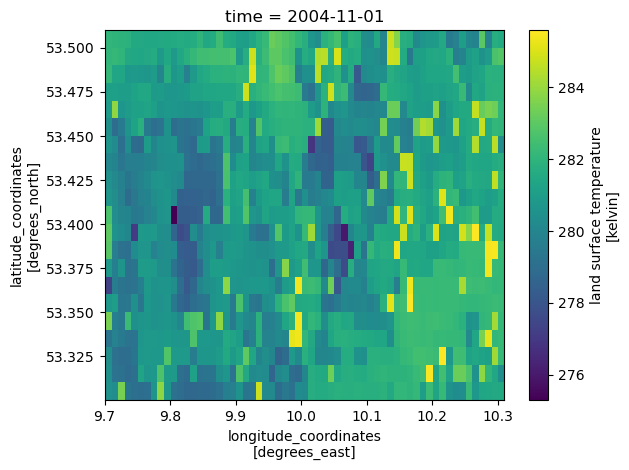

In [13]:
ds.lst.isel(time=100).plot.imshow()

Use the coverage data to plot a graph of land surface temperature against time for a specific location.

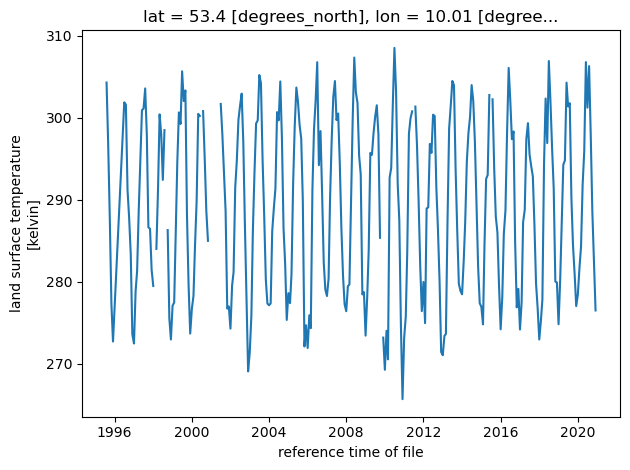

In [14]:
ds.lst.sel(lat=53.4, lon=10.0, method="nearest").plot()